# Persian Sentence Classification with Word and Sentence Labels

In [ ]:
pip install pandas scikit-learn transformers torch

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


X_train = train_data['words']
y_train_intent = train_data['intent_label']
y_train_boi = train_data['words_label']

X_test = test_data['words']
y_test_intent = test_data['intent_label']
y_test_boi = test_data['words_label']

In [ ]:
train_data.head()

,Unnamed: 0,words,words_label,intent_label
0,0,آب و هوا ابریه,O O O O,Get_Weather
1,1,از میدان نقش جهان تا مدرسه هزینه چند ریال م...,O B-Departure I-Departure I-Departure O B-Dest...,Catch_a_Cab
2,2,پسفردا درجه هوا در اهواز چقدر است,B-Date O O O B-Location O O,Get_Weather
3,3,میخوام برای میان وعده چهار تا هات داگ از ن...,O O O O B-Number I-Number B-Food I-Food O B-Re...,Order_Food
4,4,یک عدد تاکسی میخوام که برم میدان نقش جهان,O O O O O O B-Destination I-Destination I-Dest...,Catch_a_Cab


In [ ]:
test_data.head()

,Unnamed: 0,words,words_label,intent_label
0,500,تا تهرانپارس میخوام آژانس بگیرم,O B-Destination O O O,Catch_a_Cab
1,501,میشه از رستوران ارکید برای ناهار یه دونه سال...,O O B-Restaurant I-Restaurant O O B-Number I-N...,Order_Food
2,502,من یک عدد کباب برگ از نزدیک ترین کافه میخوام,O B-Number I-Number B-Food I-Food O B-Restaura...,Order_Food
3,503,لطفا از رستوران ارکید برای میان وعده یه دونه...,O O B-Restaurant I-Restaurant O O O B-Number I...,Order_Food
4,504,بهترین ترانه هفته را پخش کن,O O O O O O,Play_Music


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train_intent)


svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train_intent)


nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_intent)

MultinomialNB()

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch


model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(y_train_intent.unique()))

def tokenize(batch):
    return tokenizer(batch['words'], padding=True, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_intent_encoded = label_encoder.fit_transform(y_train_intent)
y_test_intent_encoded = label_encoder.transform(y_test_intent)

MAX_LEN = 128

train_dataset = CustomDataset(
    texts=X_train.tolist(),
    labels=y_train_intent_encoded,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = CustomDataset(
    texts=X_test.tolist(),
    labels=y_test_intent_encoded,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [90]:
convert = set()
for i in range(len(y_test_intent_encoded)):
  convert.add((y_test_intent_encoded[i],y_test_intent[i]))

In [91]:
print(convert)

{(3, 'Play_Music'), (2, 'Order_Food'), (0, 'Catch_a_Cab'), (1, 'Get_Weather')}


In [ ]:
!pip uninstall accelerate transformers

Found existing installation: accelerate 0.31.0
Uninstalling accelerate-0.31.0:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-estimate-memory
    /usr/local/bin/accelerate-launch
    /usr/local/bin/accelerate-merge-weights
    /usr/local/lib/python3.10/dist-packages/accelerate-0.31.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/accelerate/*
Proceed (Y/n)? y
  Successfully uninstalled accelerate-0.31.0
Found existing installation: transformers 4.42.3
Uninstalling transformers-4.42.3:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.42.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.42.3


In [ ]:
!pip install accelerate transformers

  Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)
  Using cached transformers-4.42.3-py3-none-any.whl (9.3 MB)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.284500,1.199480,0.745902,0.751859,0.745551,0.738920
2,0.947900,0.696804,0.893443,0.897943,0.894605,0.890194
3,0.395300,0.154260,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=96, training_loss=0.9431638109187285, metrics={'train_runtime': 1991.7811, 'train_samples_per_second': 0.753, 'train_steps_per_second': 0.048, 'total_flos': 98668417536000.0, 'train_loss': 0.9431638109187285, 'epoch': 3.0})

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate_model(model, X, y):
    kf = KFold(n_splits=5)
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        accuracies.append(accuracy_score(y_val_fold, y_pred))
        precisions.append(precision_score(y_val_fold, y_pred, average='macro'))
        recalls.append(recall_score(y_val_fold, y_pred, average='macro'))
        f1s.append(f1_score(y_val_fold, y_pred, average='macro'))

    return {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s))
    }

metrics_log_reg = evaluate_model(log_reg, X_train_tfidf, y_train_intent_encoded)
metrics_svm = evaluate_model(svm, X_train_tfidf, y_train_intent_encoded)
metrics_nb = evaluate_model(nb, X_train_tfidf, y_train_intent_encoded)

In [ ]:
metrics_bert = trainer.evaluate()

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=1)

In [ ]:
metrics_bert = {
    'accuracy': (accuracy_score(labels, pred_labels), accuracy_score(labels, pred_labels)),
    'precision': (precision_score(labels, pred_labels, average='macro'), precision_score(labels, pred_labels, average='macro')),
    'recall': (recall_score(labels, pred_labels, average='macro'), recall_score(labels, pred_labels, average='macro')),
    'f1': (f1_score(labels, pred_labels, average='macro'), f1_score(labels, pred_labels, average='macro'))
}

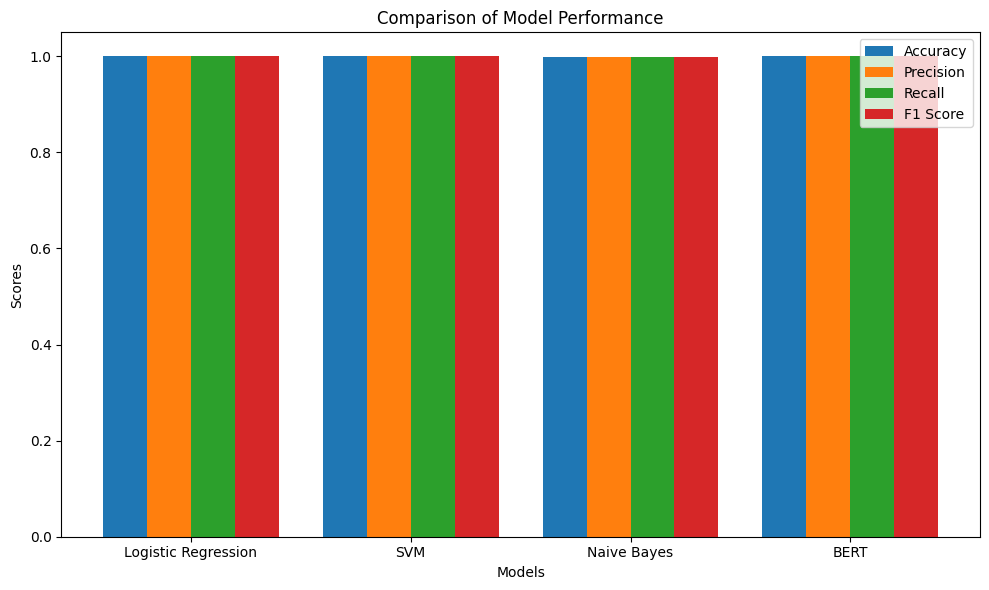

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'Logistic Regression': metrics_log_reg,
    'SVM': metrics_svm,
    'Naive Bayes': metrics_nb,
    'BERT': metrics_bert
}

labels = list(metrics.keys())
accuracy = [metrics[model].get('accuracy', (0, 0))[0] for model in labels]
precision = [metrics[model].get('precision', (0, 0))[0] for model in labels]
recall = [metrics[model].get('recall', (0, 0))[0] for model in labels]
f1 = [metrics[model].get('f1', (0, 0))[0] for model in labels]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2

rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1 Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [107]:
!mkdir models

In [105]:
import joblib

In [108]:
joblib.dump(log_reg, './models/log_reg_model.pkl')
joblib.dump(svm, './models/svm_model.pkl')
joblib.dump(nb, './models/nb_model.pkl')
joblib.dump(vectorizer, './models/tfidf_vectorizer.pkl')

['./models/tfidf_vectorizer.pkl']

In [109]:
torch.save(model.state_dict(), './models/bert_model_weights.pth')
joblib.dump(label_encoder, './models/label_encoder.pkl')

['./models/label_encoder.pkl']

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
!zip -r /content/drive/MyDrive/models.zip models/

  adding: models/ (stored 0%)
  adding: models/bert_model_weights.pth (deflated 7%)
  adding: models/svm_model.pkl (deflated 42%)
  adding: models/label_encoder.pkl (deflated 28%)
  adding: models/tfidf_vectorizer.pkl (deflated 57%)
  adding: models/nb_model.pkl (deflated 68%)
  adding: models/log_reg_model.pkl (deflated 13%)


In [110]:
log_reg_model = joblib.load('./models/log_reg_model.pkl')
svm_model = joblib.load('./models/svm_model.pkl')
nb_model = joblib.load('./models/nb_model.pkl')
label_encoder = joblib.load('./models/label_encoder.pkl')

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

bert_model.load_state_dict(torch.load('./models/bert_model_weights.pth'))

vectorizer = joblib.load('./models/tfidf_vectorizer.pkl')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
def predict_intent(sentence):
    sentence_vector = vectorizer.transform([sentence])

    log_reg_pred = log_reg_model.predict(sentence_vector)
    svm_pred = svm_model.predict(sentence_vector)
    nb_pred = nb_model.predict(sentence_vector)

    encoding = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    bert_pred_id = torch.argmax(logits, dim=1).item()
    bert_pred = ''
    for item in convert:
      if item[0] == bert_pred_id:
        bert_pred = item[1]

    print(f"Sentence: {sentence}")
    print(f"Logistic Regression Prediction: {log_reg_pred[0]}")
    print(f"SVM Prediction: {svm_pred[0]}")
    print(f"Naive Bayes Prediction: {nb_pred[0]}")
    print(f"BERT Prediction: {bert_pred}")


In [112]:
text = "یکی از آهنگ های بهنام بانی را پخش کن."
predict_intent(text)

Sentence: یکی از آهنگ های بهنام بانی را پخش کن.
Logistic Regression Prediction: Play_Music
SVM Prediction: Play_Music
Naive Bayes Prediction: Play_Music
BERT Prediction: Play_Music
